In [1]:
import copy
import torch
from torch.utils.data import *
from transformers import *
import inspect
import sys
sys.path.insert(0, "..")

from models import *
from logic import *
from my_datasets import *

from utils import *

import numpy as np

from tqdm.auto import tqdm

/home/akhare/miniconda3/envs/tfl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/akhare/miniconda3/envs/tfl/lib/python3.11/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/home/akhare/miniconda3/envs/tfl/lib/python3.11/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [29]:
n, r = 5, 8
ap, bp, tp = 0.2, 0.2, 0.4

qed_train_dataset_config = OneShotQedDatasetConfig(r, n, ap, bp, tp, num_items=1000, base_seed=1234)
qed_test_dataset_config = OneShotQedDatasetConfig(r, n, ap, bp, tp, num_items=1000, base_seed=2345)
qed_train_dataset = OneShotQedDataset(qed_train_dataset_config)
qed_test_dataset = OneShotQedDataset(qed_test_dataset_config)

succ_train_dataset_config = PredictSuccDatasetConfig(r, n, ap, bp, tp, num_items=1000, base_seed=1234)
succ_test_dataset_config = PredictSuccDatasetConfig(r, n, ap, bp, tp, num_items=500, base_seed=2345)
succ_train_dataset = PredictSuccDataset(succ_train_dataset_config)
succ_test_dataset = PredictSuccDataset(succ_test_dataset_config)

In [30]:
train_batch_size = 24
eval_batch_size = 24

qed_train_dataloader = DataLoader(
    qed_train_dataset, shuffle=True, batch_size=train_batch_size
)

qed_eval_dataloader = DataLoader(
    qed_train_dataset, batch_size=eval_batch_size
)

In [4]:
for batch in qed_train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'rules': torch.Size([24, 8, 10]),
 'theorem': torch.Size([24, 5]),
 'labels': torch.Size([24])}

In [31]:
mytf_config = MyTfConfig(embed_dim=768, ffwd_width=1024, ffwd_depth=4, num_heads=2, num_layers=8)
mytf_model = get_seq2seq_model("mytf", config=mytf_config)
mytf_qed_model = OneShotQedTaskModel(OneShotQedTaskConfig(r, n, copy.deepcopy(mytf_model)))
mytf_succ_model = PredictSuccTaskModel(PredictSuccTaskConfig(r, n, copy.deepcopy(mytf_model)))

mygpt2_model = get_seq2seq_model("gpt2", use_pretrained=True)
mygpt2_qed_model = OneShotQedTaskModel(OneShotQedTaskConfig(r, n, copy.deepcopy(mygpt2_model)))
mygpt2_succ_model = PredictSuccTaskModel(PredictSuccTaskConfig(r, n, copy.deepcopy(mygpt2_model)))

loading configuration file config.json from cache at /home/akhare/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.34.1",
  "u

In [6]:
outputs = mygpt2_qed_model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.7517, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) torch.Size([24])


In [7]:
qed_training_args = TrainingArguments(
    "test-trainer",
    evaluation_strategy = "epoch",
    num_train_epochs = 100,
    per_device_train_batch_size = 24,
    per_device_eval_batch_size = 24,
    logging_steps = 5
)

succ_training_args = qed_training_args

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [8]:
qed_training_args

TrainingArguments(
_n_gpu=4,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_always_pu

In [32]:
class EvalObject:
    def __init__(self, predictions, labels, losses=None):
        self.predictions = predictions
        self.label_ids = labels
        self.losses = losses

def evaluate(model, eval_dataloader, compute_metrics):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.eval()
    all_predictions = []
    all_labels = []
    all_losses = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        # Predictions are logits for BCELoss tasks
        predictions = logits
        all_predictions.extend(predictions.cpu().detach().tolist())
        all_labels.extend(batch['labels'].cpu().tolist())
        all_losses.append(loss.cpu().detach())

    return compute_metrics(EvalObject(
        np.asarray(all_predictions, dtype=object), 
        np.asarray(all_labels, dtype=object), 
        np.asarray(all_losses)))

In [33]:
def train(model, num_epochs, train_dataloader, eval_dataloader=None, compute_metrics=None):
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    progress_bar = tqdm(range(num_training_steps))

    model.train()
    train_losses_list = []
    val_metrics_list = []
    for epoch in range(num_epochs):
        epoch_loss_list = []
        print(f"============Training metrics for epoch {epoch}=========")
        for batch_id, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_loss_list.append(loss.cpu().detach())
            
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            # print(f"Batch {batch_id}: Loss: {loss}")

        print(f"Epoch loss: {np.array(epoch_loss_list).mean()}")
        train_losses_list.append(np.array(epoch_loss_list).mean())

        # Evaluate after every epoch
        if eval_dataloader is not None and compute_metrics is not None:
            eval_metrics = evaluate(model, eval_dataloader, compute_metrics)
            print(f"============Validation metrics for epoch {epoch}=========")
            print(eval_metrics)
            val_metrics_list.append(eval_metrics)

    return train_losses_list, val_metrics_list

In [34]:
n_epochs = 20

train_losses_list, val_metrics_list = train(mygpt2_qed_model, n_epochs, qed_train_dataloader, qed_eval_dataloader, qed_compute_metrics)

  0%|          | 2/840 [00:00<00:54, 15.52it/s]

============Training metrics for epoch 0=========


  5%|▌         | 42/840 [00:02<00:47, 16.66it/s]

Epoch loss: 0.7036917805671692


  5%|▌         | 44/840 [00:03<02:44,  4.84it/s]

============Validation metrics for epoch 0=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6856713}
============Training metrics for epoch 1=========


 10%|▉         | 83/840 [00:05<00:35, 21.37it/s]

Epoch loss: 0.6890601515769958


 10%|█         | 86/840 [00:06<01:39,  7.57it/s]

============Validation metrics for epoch 1=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6850947}
============Training metrics for epoch 2=========


 15%|█▍        | 125/840 [00:08<00:33, 21.54it/s]

Epoch loss: 0.6871573328971863


 15%|█▌        | 128/840 [00:09<01:33,  7.60it/s]

============Validation metrics for epoch 2=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6841769}
============Training metrics for epoch 3=========


 20%|█▉        | 167/840 [00:10<00:31, 21.55it/s]

Epoch loss: 0.686660885810852


 20%|██        | 170/840 [00:11<01:28,  7.57it/s]

============Validation metrics for epoch 3=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68403345}
============Training metrics for epoch 4=========


 25%|██▍       | 209/840 [00:13<00:29, 21.47it/s]

Epoch loss: 0.6864696145057678


 25%|██▌       | 212/840 [00:14<01:22,  7.62it/s]

============Validation metrics for epoch 4=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68403435}
============Training metrics for epoch 5=========


 30%|██▉       | 251/840 [00:16<00:27, 21.58it/s]

Epoch loss: 0.6861869692802429


 30%|███       | 254/840 [00:17<01:15,  7.72it/s]

============Validation metrics for epoch 5=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840291}
============Training metrics for epoch 6=========


 35%|███▍      | 292/840 [00:19<00:25, 21.47it/s]

Epoch loss: 0.6857951283454895


 35%|███▌      | 298/840 [00:20<00:57,  9.47it/s]

============Validation metrics for epoch 6=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68402916}
============Training metrics for epoch 7=========


 40%|███▉      | 334/840 [00:22<00:23, 21.55it/s]

Epoch loss: 0.6856781244277954


 40%|████      | 340/840 [00:23<00:52,  9.45it/s]

============Validation metrics for epoch 7=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68403065}
============Training metrics for epoch 8=========


 45%|████▌     | 378/840 [00:24<00:21, 21.78it/s]

Epoch loss: 0.6855252981185913


 45%|████▌     | 381/840 [00:25<00:59,  7.66it/s]

============Validation metrics for epoch 8=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68403465}
============Training metrics for epoch 9=========


 50%|█████     | 420/840 [00:27<00:19, 21.61it/s]

Epoch loss: 0.6853387355804443


 50%|█████     | 423/840 [00:28<00:54,  7.62it/s]

============Validation metrics for epoch 9=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68402904}
============Training metrics for epoch 10=========


 55%|█████▌    | 462/840 [00:30<00:17, 21.67it/s]

Epoch loss: 0.6851621866226196


 55%|█████▌    | 465/840 [00:31<00:49,  7.61it/s]

============Validation metrics for epoch 10=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840267}
============Training metrics for epoch 11=========


 60%|██████    | 504/840 [00:33<00:15, 21.67it/s]

Epoch loss: 0.6850393414497375


 60%|██████    | 507/840 [00:34<00:43,  7.61it/s]

============Validation metrics for epoch 11=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840245}
============Training metrics for epoch 12=========


 65%|██████▌   | 546/840 [00:35<00:13, 21.75it/s]

Epoch loss: 0.6849284172058105


 65%|██████▌   | 549/840 [00:36<00:38,  7.62it/s]

============Validation metrics for epoch 12=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840222}
============Training metrics for epoch 13=========


 70%|███████   | 588/840 [00:38<00:11, 21.73it/s]

Epoch loss: 0.6848154067993164


 70%|███████   | 591/840 [00:39<00:32,  7.69it/s]

============Validation metrics for epoch 13=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840205}
============Training metrics for epoch 14=========


 75%|███████▌  | 630/840 [00:41<00:09, 21.76it/s]

Epoch loss: 0.6847101449966431


 75%|███████▌  | 633/840 [00:42<00:27,  7.62it/s]

============Validation metrics for epoch 14=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840184}
============Training metrics for epoch 15=========


 80%|███████▉  | 671/840 [00:44<00:07, 21.62it/s]

Epoch loss: 0.6846144795417786


 80%|████████  | 674/840 [00:45<00:21,  7.56it/s]

============Validation metrics for epoch 15=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68401843}
============Training metrics for epoch 16=========


 85%|████████▍ | 713/840 [00:47<00:05, 21.63it/s]

Epoch loss: 0.684508740901947


 85%|████████▌ | 716/840 [00:47<00:16,  7.69it/s]

============Validation metrics for epoch 16=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840177}
============Training metrics for epoch 17=========


 90%|████████▉ | 755/840 [00:49<00:03, 21.67it/s]

Epoch loss: 0.6844069361686707


 90%|█████████ | 758/840 [00:50<00:10,  7.67it/s]

============Validation metrics for epoch 17=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68401766}
============Training metrics for epoch 18=========


 95%|█████████▍| 797/840 [00:52<00:01, 21.52it/s]

Epoch loss: 0.6843061447143555


 95%|█████████▌| 800/840 [00:53<00:05,  7.59it/s]

============Validation metrics for epoch 18=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.68401766}
============Training metrics for epoch 19=========


100%|█████████▉| 839/840 [00:55<00:00, 21.50it/s]

Epoch loss: 0.6842058897018433


100%|██████████| 840/840 [00:56<00:00, 14.95it/s]

============Validation metrics for epoch 19=========
{'Accuracy': 0.568, 'Avg Ones': 1.0, 'Loss': 0.6840182}


In [35]:
from matplotlib.pylab import plt

def plot_metric(epochs, metrics_dict, title, metrics_label):
    """
    Plot metrics per epoch
    """

    for label, metric in metrics_dict.items():
        plt.plot(epochs, metric, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics_label)
    plt.xticks(range(0, len(epochs), 1))
    plt.legend(loc='best')
    plt.show()

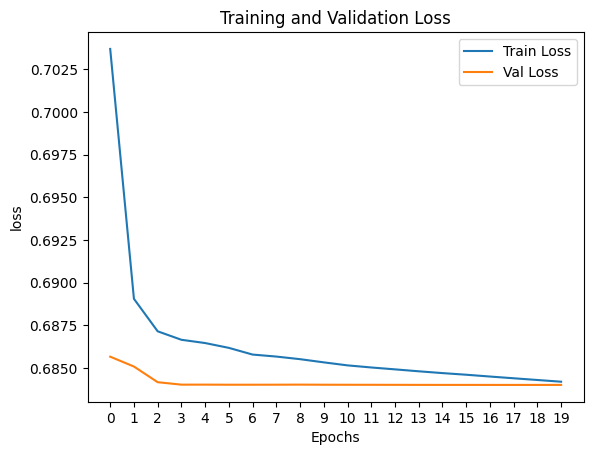

In [36]:
loss_dict = {
    "Train Loss": train_losses_list,
    "Val Loss": [x["Loss"] for x in val_metrics_list]
}

plot_metric(list(range(n_epochs)), loss_dict, "Training and Validation Loss", "loss")

In [5]:
### QED GPT2
mygpt2_qed_trainer = Trainer(mygpt2_qed_model, qed_training_args,
    train_dataset = qed_train_dataset,
    eval_dataset = qed_test_dataset,
    compute_metrics = qed_compute_metrics)
# mygpt2_qed_trainer.train()

In [6]:
### QED MyTf
mytf_qed_trainer = Trainer(mytf_qed_model, qed_training_args,
    train_dataset = qed_train_dataset,
    eval_dataset = qed_test_dataset,
    compute_metrics = qed_compute_metrics)
# mytf_qed_trainer.train()

In [ ]:
### SUCC GPT2
mygpt2_succ_trainer = Trainer(mygpt2_succ_model, succ_training_args,
    train_dataset = succ_train_dataset,
    eval_dataset = succ_test_dataset,
    compute_metrics = succ_compute_metrics)
mygpt2_succ_trainer.train()

***** Running training *****
  Num examples = 1,000
  Num Epochs = 100
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 4,200
  Number of trainable parameters = 126,424,325


Epoch,Training Loss,Validation Loss,Accuracy,Avg ones
1,0.533100,0.538160,0.779200,1.000000
2,0.547400,0.531928,0.779200,1.000000
3,0.528100,0.540472,0.779200,1.000000
4,0.523000,0.535523,0.779200,1.000000
5,0.459200,0.562002,0.779200,1.000000
6,0.444900,0.567684,0.779200,1.000000
7,0.373100,0.550001,0.779200,1.000000
8,0.325000,0.719572,0.779200,1.000000
9,0.256400,0.817121,0.779200,1.000000
10,0.297800,1.107274,0.779200,1.000000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
Saving model checkpoint to test-trainer/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 24
***** Running Evaluation *****
  Nu

In [ ]:
# batch = next(iter(DataLoader(train_qed_dataset, batch_size=8)))
# mygpt2_qed_model.cpu().eval()
# print(f"training? {mygpt2_qed_model.training}")
# out = mygpt2_qed_model(**batch)

In [ ]:
mytf_trainer = Trainer(
    mytf_qed_model,
    training_args,
    train_dataset = train_qed_dataset,
    eval_dataset = test_qed_dataset,
    compute_metrics = compute_metrics)

mytf_trainer.train()

In [ ]:
inspect.getfile(mygpt2_trainer.predict)

In [ ]:
bce_loss = nn.BCELoss()

In [ ]:
bce_loss(torch.rand(3,4,5), torch.rand(3,4,5))